# Examing logs

In [42]:
%matplotlib inline
import pandas as pd
from pysindy import SINDy
import numpy as np
import matplotlib.pyplot as plt

ekf_states0 = 'csv/unstable_estimator_states_0.csv'
ekf_states1 = 'csv/unstable_estimator_states_1.csv'
dshot_output = 'csv/unstable_actuator_outputs_1.csv'

actuation = pd.read_csv(dshot_output)


print(actuation.head())

   timestamp  noutputs  output[0]  output[1]  output[2]  output[3]  output[4]  \
0   80401548         6      987.0     1014.0      987.0     1016.0        0.0   
1   80402881         6     1001.0      996.0      992.0     1014.0        0.0   
2   80601542         6     1027.0      972.0      988.0     1017.0        0.0   
3   80702188         6     1043.0      950.0     1002.0     1008.0        0.0   
4   80801475         6     1011.0      978.0     1006.0     1008.0        0.0   

   output[5]  output[6]  output[7]  output[8]  output[9]  output[10]  \
0        0.0        0.0        0.0        0.0        0.0         0.0   
1        0.0        0.0        0.0        0.0        0.0         0.0   
2        0.0        0.0        0.0        0.0        0.0         0.0   
3        0.0        0.0        0.0        0.0        0.0         0.0   
4        0.0        0.0        0.0        0.0        0.0         0.0   

   output[11]  output[12]  output[13]  output[14]  output[15]  
0         0.0   

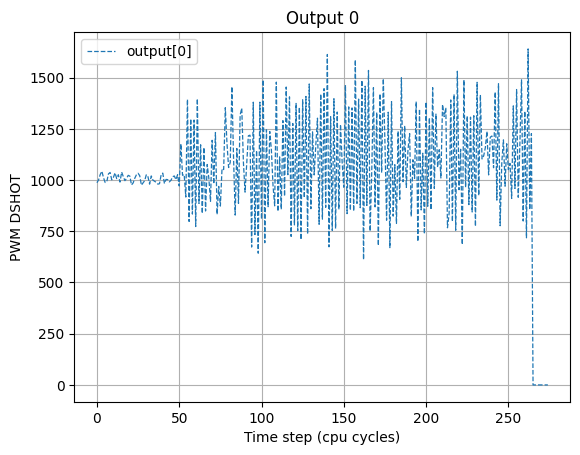

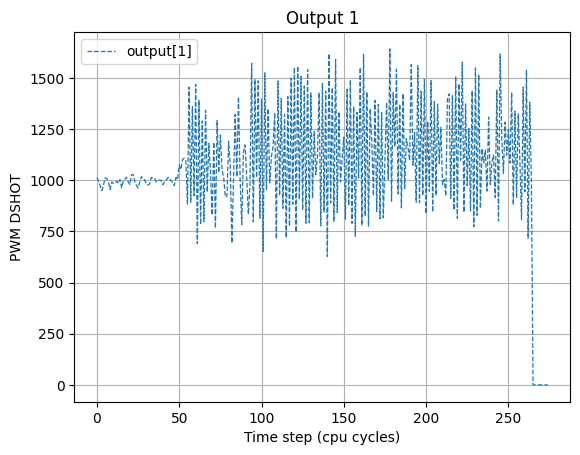

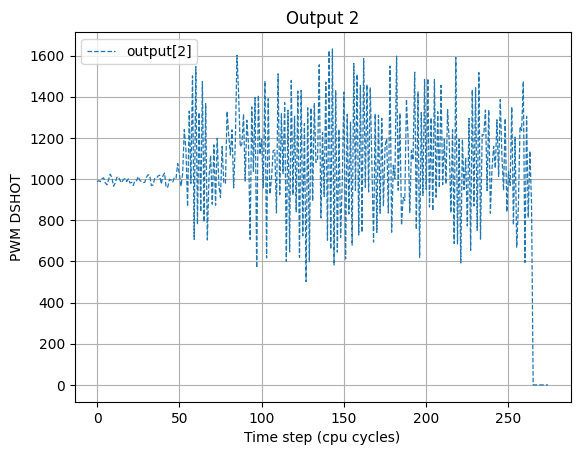

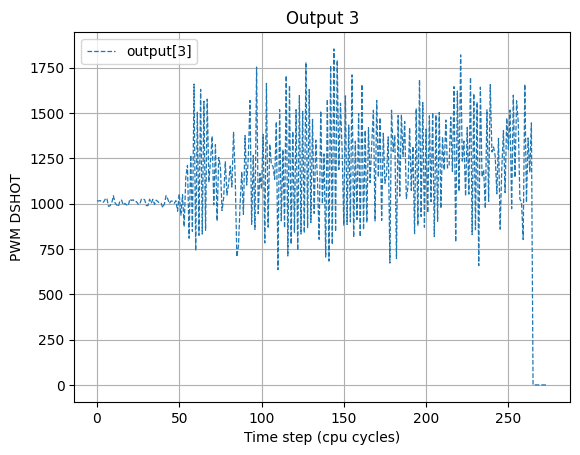

In [2]:
for i in range(4):
    ax = actuation[f'output[{i}]'].plot(kind='line', style='--', legend=True, linewidth=0.9)
    ax.set_ylabel("PWM DSHOT")
    ax.set_xlabel("Time step (cpu cycles)")
    ax.set_title(f'Output {i}')
    ax.grid()
    ax.legend([f'output[{i}]'])
    plt.show()

## State estimates

### Position Velocity Quaternion Estimates

In [3]:
"""
Quaternion defining the rotation from North, East, Down local earth frame to X, Y, Z body frame
Velocity at the IMU - North, East, Down (m/s)
Position at the IMU - North, East, Down (m)
IMU delta angle bias estimates - X, Y, Z (rad)
IMU delta velocity bias estimates - X, Y, Z (m/s)
Earth Magnetic field components - North, East, Down (gauss)
Vehicle body frame magnetic field bias - X, Y, Z (gauss)
Wind velocity - North, East (m/s)
"""

estimates0 = pd.read_csv(ekf_states0)
estimates1 = pd.read_csv(ekf_states1)
columns_with_prefix = [column for column in estimates0.columns if column.startswith('states')]

state_estimates0 = estimates0[columns_with_prefix]
state_estimates1 = estimates1[columns_with_prefix]

time0_frame = estimates0['timestamp']
time1_frame = estimates1['timestamp']

# Helper function to extract specific ranges from the DataFrame and convert to a NumPy matrix
def extract_to_matrix(df, start, end):
    return df.iloc[:, start:end].values

# Attitude (quaternion) is assumed to be in the first 4 'states' columns
attitude0 = extract_to_matrix(state_estimates0, 0, 4)
attitude1 = extract_to_matrix(state_estimates1, 0, 4)

# Velocity is assumed to be in the next 3 'states' columns
velocity0 = extract_to_matrix(state_estimates0, 4, 7)
velocity1 = extract_to_matrix(state_estimates1, 4, 7)

# Position is assumed to be in the next 3 'states' columns
position0 = extract_to_matrix(state_estimates0, 7, 10)
position1 = extract_to_matrix(state_estimates1, 7, 10)

time0 = time0_frame.values
time1 = time1_frame.values

# Printing shapes as a quick check
print("Attitude0 Shape:", attitude0.shape)
print("Velocity0 Shape:", velocity0.shape)
print("Position0 Shape:", position0.shape)
print(time0.shape)

Attitude0 Shape: (27, 4)
Velocity0 Shape: (27, 3)
Position0 Shape: (27, 3)
(27,)


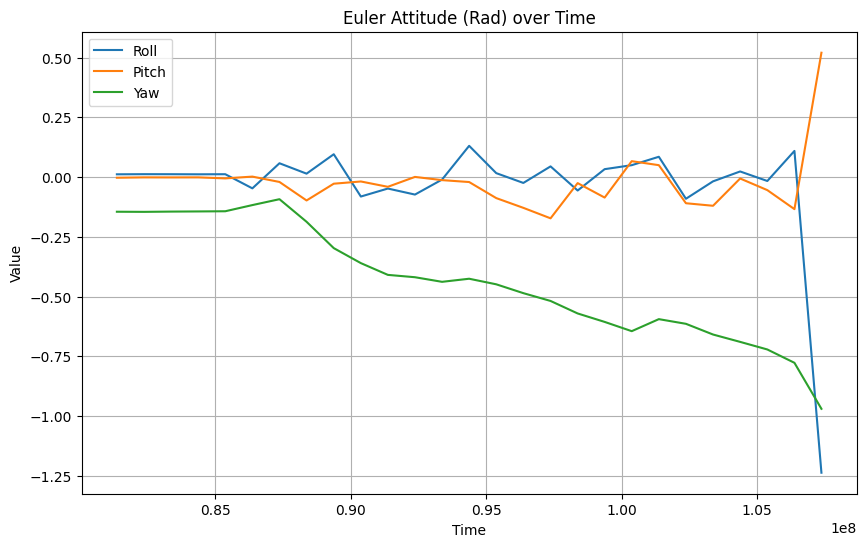

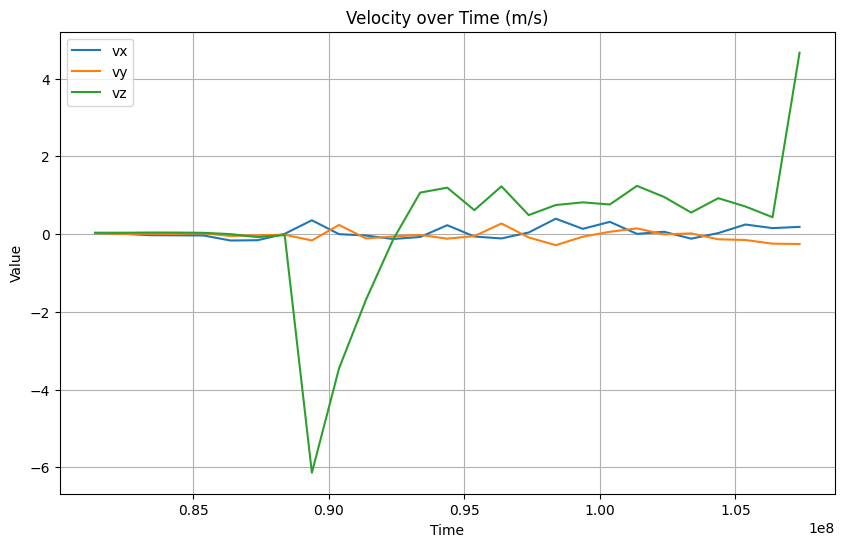

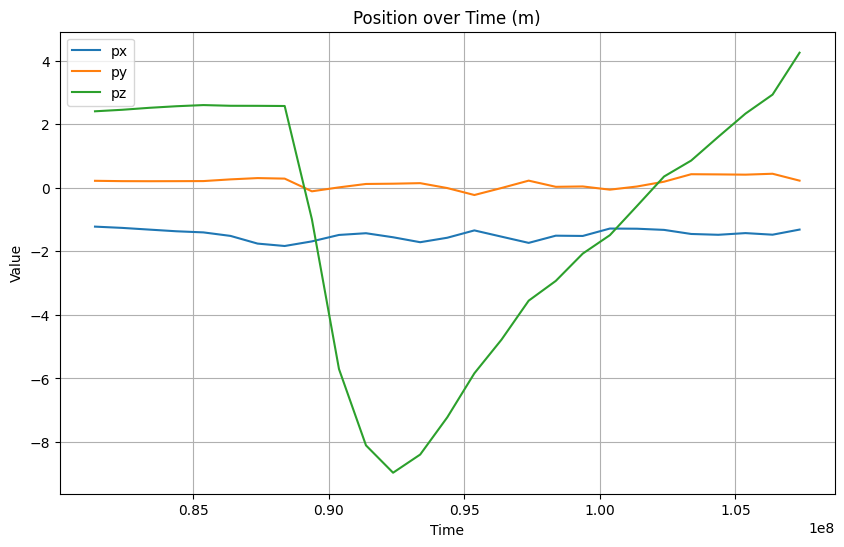

In [49]:
def quaternion_to_euler(q):
    """
    Converts quaternion (w, x, y, z) to Euler angles (roll, pitch, yaw)
    """
    # Extract the values from Q
    q0, q1, q2, q3 = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
    
    # Roll (phi)
    roll = np.arctan2(2*(q0*q1 + q2*q3), 1 - 2*(q1**2 + q2**2))
    
    # Pitch (theta)
    pitch = np.arcsin(2*(q0*q2 - q3*q1))
    
    # Yaw (psi)
    yaw = np.arctan2(2*(q0*q3 + q1*q2), 1 - 2*(q2**2 + q3**2))
    
    return roll, pitch, yaw

def plot_component(time, component_matrix, component_labels, title):
    """
    Plots each column of the component matrix against time.

    Parameters:
    - time: NumPy array of time values
    - component_matrix: NumPy matrix of the component values (e.g., velocity)
    - component_labels: List of strings representing labels for each matrix column
    - title: String for the plot title
    """
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    for i, label in enumerate(component_labels):
        plt.plot(time, component_matrix[:, i], label=label)

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()


roll0, pitch0, yaw0 = quaternion_to_euler(attitude0)
plot_component(time0, np.column_stack((roll0, pitch0, yaw0)), ['Roll', 'Pitch', 'Yaw'], 'Euler Attitude (Rad) over Time')
plot_component(time0, velocity0, ['vx', 'vy', 'vz'], 'Velocity over Time (m/s)')
plot_component(time0, position0, ['px', 'py', 'pz'], 'Position over Time (m)')

### Acceleration and Angular Velocity Measurements

In [5]:
fused_imu_csv = 'csv/unstable_sensor_combined_0.csv'
imu_dataframe = pd.read_csv(fused_imu_csv)

# Extract column names for gyro and accelerometer data
gyro_columns = [col for col in imu_dataframe.columns if col.startswith('gyro_rad')]
accelerometer_columns = [col for col in imu_dataframe.columns if col.startswith('accelerometer_m')]

# Select only the relevant columns from the dataframe
gyro_data = imu_dataframe[gyro_columns]
accelerometer_data = imu_dataframe[accelerometer_columns]
imu_time = imu_dataframe['timestamp']

(5165, 3)
(5165, 3)
(5165,)


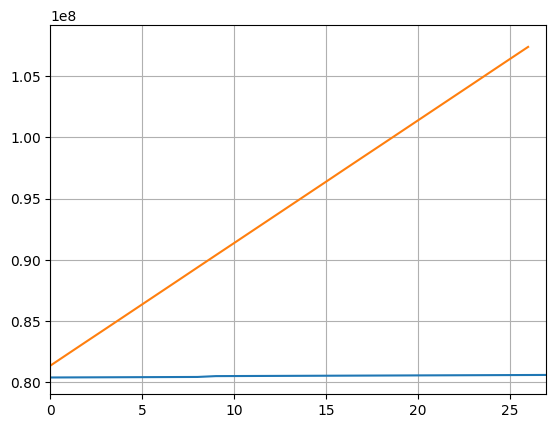

[ 80397176  80402508  80407884 ... 107801887 107807164 107812400]


In [14]:
accel_arr = accelerometer_data.values
gyro_arr = gyro_data.values
time_arr = imu_time.values

print(accel_arr.shape)
print(gyro_arr.shape)
print(time_arr.shape)

### Full state discrete index

#### Filter the closest gyro measurements by timestep

In [28]:
respective_indicies = []
for idx, time_step in enumerate(time_arr):
    tol = 2500
    for state_step in time0:
        if abs(time_step - state_step) <= tol:
            respective_indicies.append(idx)

In [29]:
accel_state = accel_arr[respective_indicies]
angular_velocity_state = gyro_arr[respective_indicies]

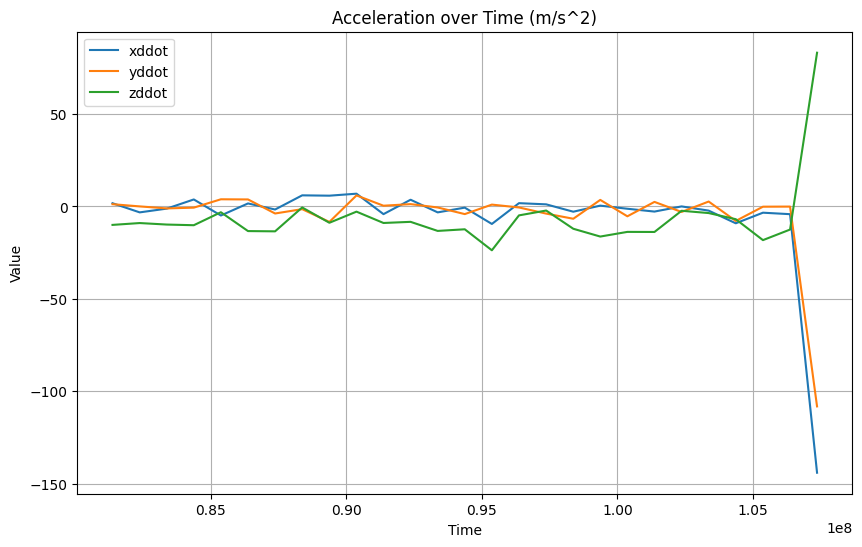

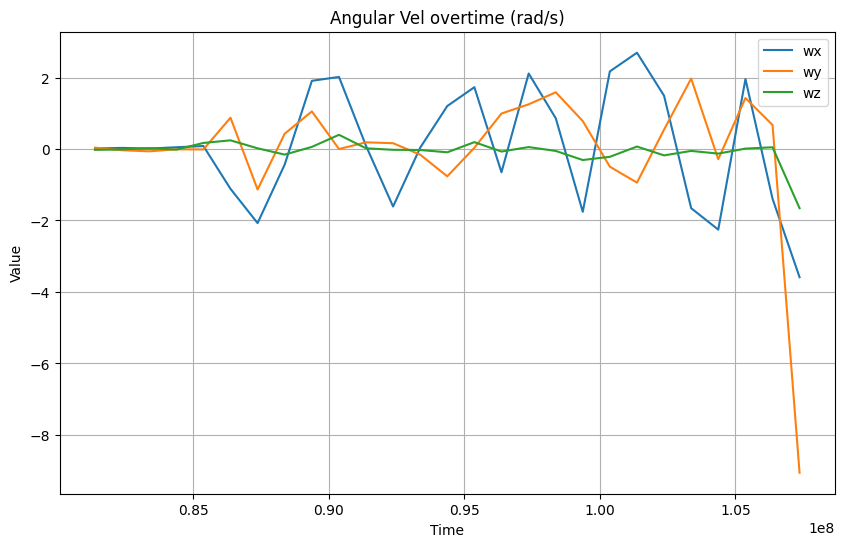

In [48]:
plot_component(time0, accel_state, ['xddot', 'yddot', 'zddot'], 'Acceleration over Time (m/s^2)')
plot_component(time0, angular_velocity_state, ['wx', 'wy', 'wz'], 'Angular Vel overtime (rad/s)')

#### Assemble into state vector matrix

In [31]:
def assemble_discrete_states(quat_attitudes, positions, velocities, angular_velocities):
    states = []
    for i in range(len(quat_attitudes)):
        attitude = quat_attitudes[i]
        pos = positions[i]
        vel = velocities[i]
        omega = angular_velocities[i]
        single_state = np.array([attitude[0], attitude[1], attitude[2], attitude[3],
                                 pos[0], pos[1], pos[2],
                                 omega[0], omega[1], omega[2],
                                 vel[0], vel[1], vel[2]])
        states.append(single_state)
    return np.array(states)

X = assemble_discrete_states(attitude0, position0, velocity0, angular_velocity_state)

In [33]:
print(X.shape)

(27, 13)


In [46]:
dshot_motor_u = actuation[[column for column in actuation.columns if column.startswith('output')]].values[:, 0:4]
dshot_motor_time = actuation['timestamp']
print(dshot_motor_u.shape)
print(dshot_motor_time.values.shape)
print(imu_time.values.shape)

(275, 4)
(275,)
(5165,)


In [60]:
def intersecting_indicies(arr1, arr2):
    respective_indicies = []
    for idx, time_step in enumerate(arr1):
        tol = 50500
        for state_step in arr2:
            if abs(time_step - state_step) <= tol:
                respective_indicies.append(idx)
    return np.array(respective_indicies)

overlapping_actuation_time = intersecting_indicies(dshot_motor_time.values, time0)

downsampled_dshot_u = dshot_motor_u[overlapping_actuation_time]

In [61]:
len(downsampled_dshot_u)

27

## Fit First Order Transfer

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Example model output calculation for one output based on all inputs
def model_output(params, inputs, time, num_inputs=4):
    Ks, taus = params[:num_inputs], params[num_inputs:2*num_inputs]
    y_model = np.zeros_like(time)
    for i in range(num_inputs):
        K, tau = Ks[i], taus[i]
        y_model += K * (1 - np.exp(-time / tau)) * inputs[:, i]
    return y_model

# Cost function for one output
def cost_function(params, inputs, output, time):
    y_model = model_output(params, inputs, time)
    error = output - y_model
    return np.sum(error**2)

# Assuming you have your inputs, outputs, and time defined
# inputs = np.random.rand(N, 4)  # N time steps, 4 inputs
# outputs = np.random.rand(N, 13)  # N time steps, 13 outputs
# time = np.linspace(0, 10, N)

inputs = downsampled_dshot_u
outputs = X
time = np.asarray(time0, dtype=np.float64)
results = []
for i in range(13):  # For each output
    output = outputs[:, i]
    # Initial guess for Ks and taus for each input to this output
    initial_guess = np.ones(8)  # 4 Ks and 4 taus
    res = minimize(cost_function, initial_guess, args=(inputs, output, time))
    results.append(res.x)

# Results of fitted first order transfer function given the dshot down sampled control inputs

In [76]:
import control
import numpy as np

# Initialize matrices for the numerator and denominator coefficients
num_matrix = []
den_matrix = []

n = 13  # Number of outputs
m = 4   # Number of inputs

# Assuming 'results' is structured as: [K_1, ..., K_m, tau_1, ..., tau_m] for each output
for params in results:
    K, tau = params[:m], params[m:2*m]
    num_row = []
    den_row = []
    for j in range(m):
        # For each input-output pair, create numerator and denominator lists
        num = [K[j]]
        den = [tau[j], 1]
        num_row.append(num)
        den_row.append(den)
    num_matrix.append(num_row)
    den_matrix.append(den_row)

# Now num_matrix and den_matrix are structured properly for MIMO system creation
# Create the MIMO transfer function
mimo_tf = control.TransferFunction(num_matrix, den_matrix, display_format='poly')

print(mimo_tf)



Input 1 to output 1:
0.000173
--------
 s + 1

Input 1 to output 2:
-6.554e-06
----------
  s + 1

Input 1 to output 3:
-2.704e-05
----------
  s + 1

Input 1 to output 4:
-0.0002977
----------
  s + 1

Input 1 to output 5:
0.0002793
---------
  s + 1

Input 1 to output 6:
0.0003208
---------
  s + 1

Input 1 to output 7:
-0.007546
---------
  s + 1

Input 1 to output 8:
-0.003117
---------
  s + 1

Input 1 to output 9:
-0.002289
---------
  s + 1

Input 1 to output 10:
-0.0006615
----------
  s + 1

Input 1 to output 11:
-0.0003841
----------
  s + 1

Input 1 to output 12:
0.0002149
---------
  s + 1

Input 1 to output 13:
0.00923
-------
 s + 1

Input 2 to output 1:
1.04e-05
--------
 s + 1

Input 2 to output 2:
-0.0001211
----------
  s + 1

Input 2 to output 3:
-6.634e-05
----------
  s + 1

Input 2 to output 4:
-0.0005045
----------
  s + 1

Input 2 to output 5:
0.0001303
---------
  s + 1

Input 2 to output 6:
0.0004448
---------
  s + 1

Input 2 to output 7:
-0.008242
---------

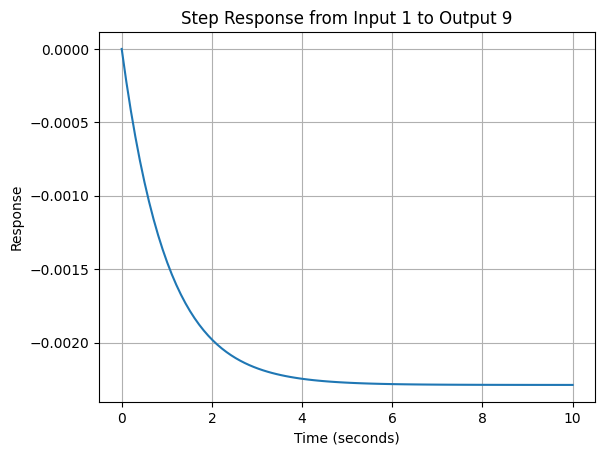

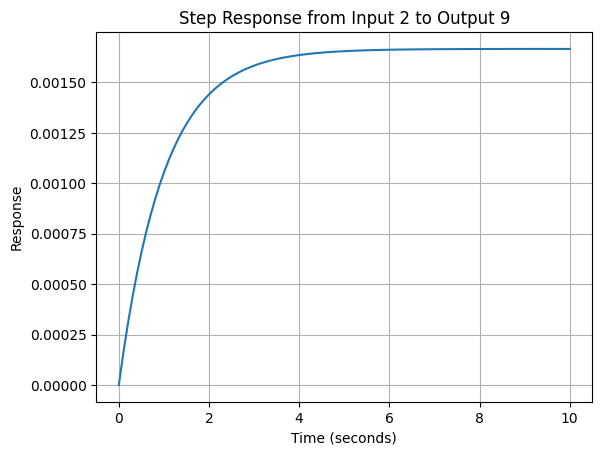

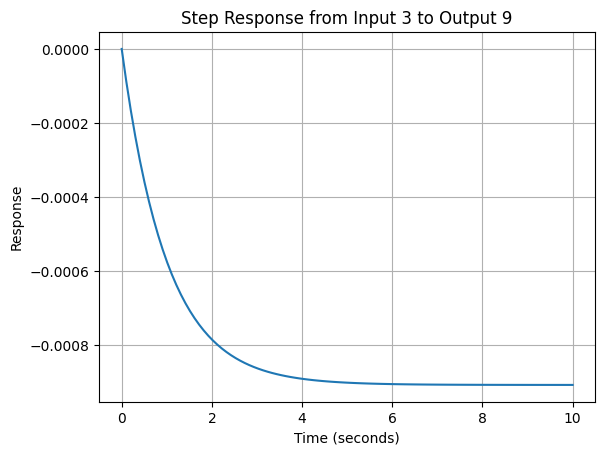

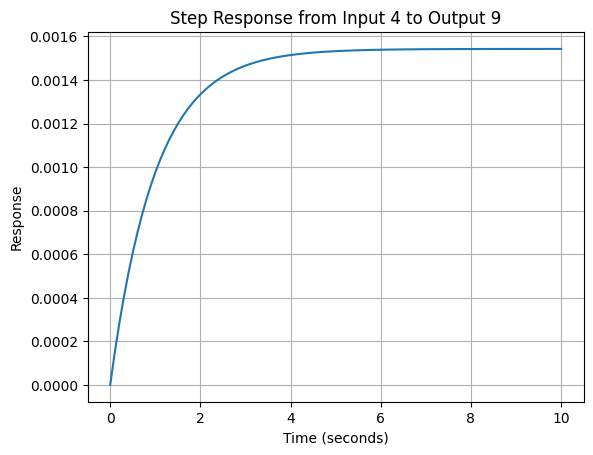

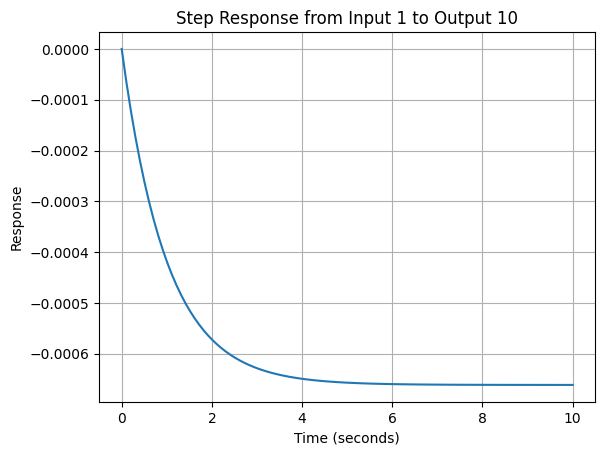

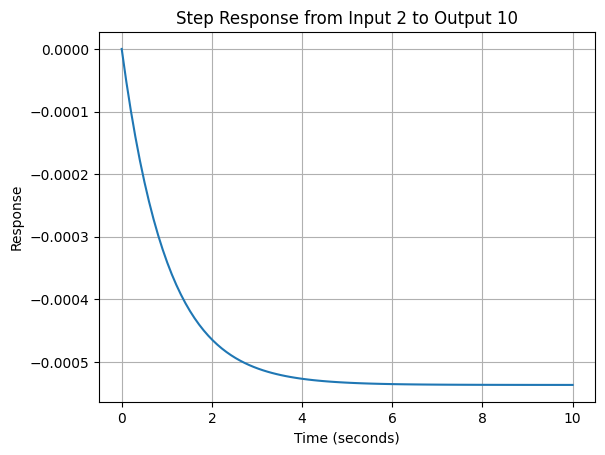

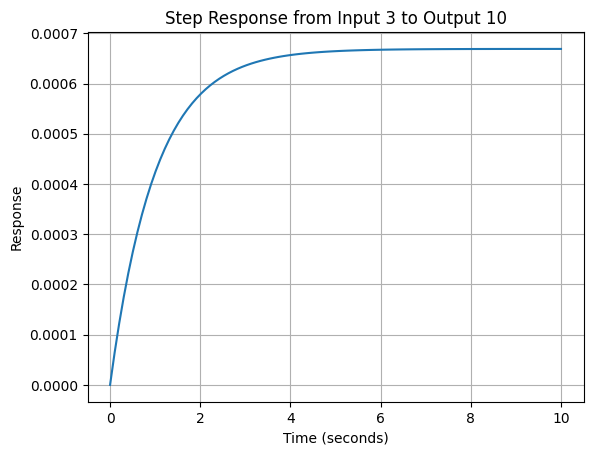

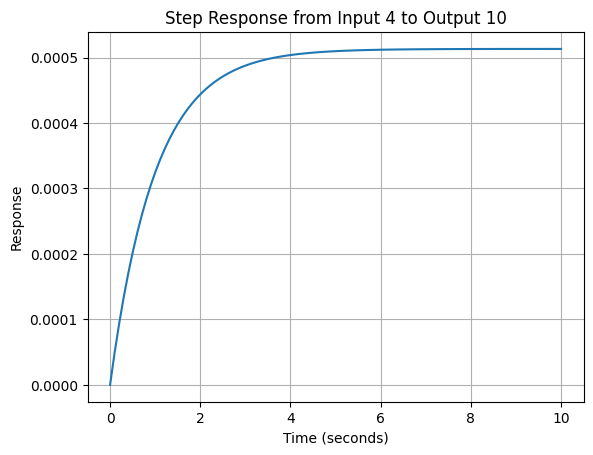

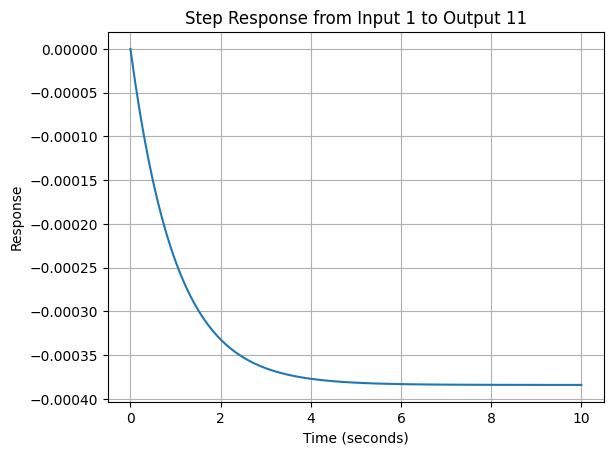

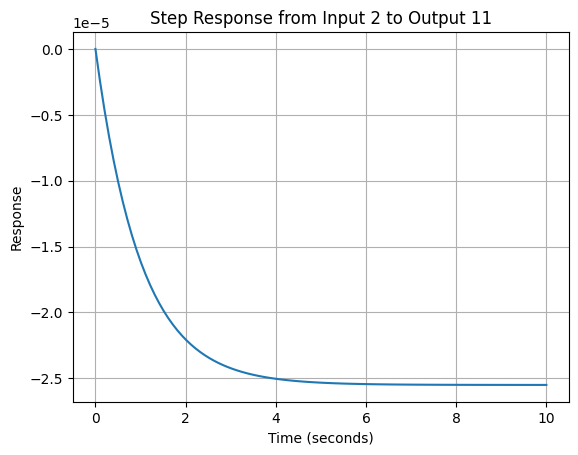

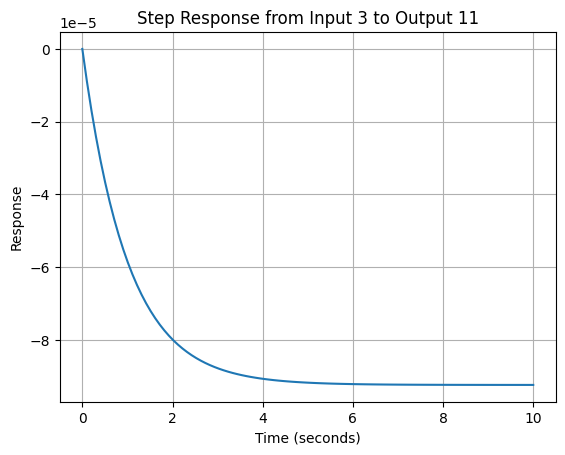

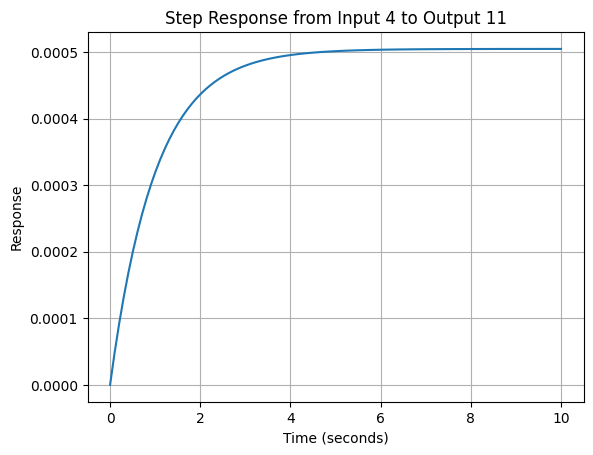

In [80]:

import matplotlib.pyplot as plt

# Function to plot step responses for a MIMO system
def plot_mimo_step_response(mimo_tf, n, m):
    time_span = np.linspace(0, 10, 100)  # Define time span for step response

    # Iterate through each input-output pair
    for i in range(8, 11):  # n outputs
        for j in range(m):  # m inputs
            # Extract the SISO transfer function for the current input-output pair
            siso_tf = control.minreal(mimo_tf[i, j], verbose=False)
            
            # Compute the step response for this SISO transfer function
            t, yout = control.step_response(siso_tf, T=time_span)
            
            # Plot
            plt.figure()
            plt.plot(t, yout)
            plt.title(f'Step Response from Input {j+1} to Output {i+1}')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Response')
            plt.grid(True)
            plt.show()

# Call the function with your MIMO transfer function, number of outputs (n), and inputs (m)
plot_mimo_step_response(mimo_tf, n, m)
